# Importing Required Libraries

In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
import miceforest as miceforest

from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Function Definitions

In [2]:
# Function to generate model training and validation scores

def ScorePrinter(y_train_smote, y_pred, y_val, y_pred_val):
    train_report = classification_report(y_train_smote, y_pred) #classification report(model scores) for training data
    val_report = classification_report(y_val, y_pred_val)       #classification report(model scores) for validation data
    print(train_report)
    print("*"*50)
    print(val_report)
    val_report = classification_report(y_val, y_pred_val, output_dict=True)
    return val_report


In [3]:
# Function to plot ROC curves for model

def ROCprint(y_train_smote, y_pred, y_val, y_pred_val):
    FPR, TPR, _ = roc_curve(y_train_smote, y_pred)
    val_FPR, val_TPR, _ = roc_curve(y_val, y_pred_val)

    train_auc = auc(FPR, TPR)
    val_auc = auc(val_FPR, val_TPR)

    plt.figure()
    plt.plot([0,1], [0,1], '--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(FPR, TPR, '.-', label=f'TrainING set ROC; Area:{round(train_auc, 4)}')
    plt.plot(val_FPR, val_TPR, '.-', label=f'Validation set ROC; Area:{round(val_auc, 4)}')
    plt.grid(True)
    plt.legend(loc="best")
    plt.title("ROC CurveS")
    plt.show()



# Importing Miceforest Imputed Data

In [10]:
#Importing

Training_data = pd.read_csv('TrainingData.csv')

data = Training_data
data.replace(["C", "L"], [0,1], inplace=True) #Replacing Credit and Lending Card with [0,1]
data = data.drop(columns=['application_key'])
data = data.apply(pd.to_numeric, errors='coerce') #Convering missing values place-holders like missing, na, N/A etc. into NaN

X = data
y = data["default_ind"]

#MICE Imputation
#Initialisation of miceforest imputer kernel

kernel = miceforest.ImputationKernel(     
  data=X,
  save_all_iterations=True,
  random_state=8
)

kernel.mice(6,verbose=True)  #Kernel will perform 6 iteration in order to impute missing values in dataset

new_data_imputed = kernel.impute_new_data(X)
# Return a completed dataset
X = new_data_imputed.complete_data(0)
X.drop(["default_ind"],axis=1,inplace=True)

Initialized logger with name mice 1-6
Dataset 0
1  | mvar19 | mvar34 | mvar28 | mvar38 | mvar20 | mvar29 | mvar5 | mvar4 | mvar3 | mvar10 | mvar43 | mvar33 | mvar42 | mvar36 | mvar50 | mvar51 | mvar1 | mvar2 | mvar39 | mvar7 | mvar37 | mvar25 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30 | mvar23 | mvar45 | mvar11 | mvar41 | mvar31 | mvar40
2  | mvar19 | mvar34 | mvar28 | mvar38 | mvar20 | mvar29 | mvar5 | mvar4 | mvar3 | mvar10 | mvar43 | mvar33 | mvar42 | mvar36 | mvar50 | mvar51 | mvar1 | mvar2 | mvar39 | mvar7 | mvar37 | mvar25 | mvar32 | mvar44 | mvar13 | mvar26 | mvar9 | mvar27 | mvar12 | mvar18 | mvar17 | mvar16 | mvar24 | mvar6 | mvar8 | mvar21 | mvar46 | mvar22 | mvar15 | mvar35 | mvar30 | mvar23 | mvar45 | mvar11 | mvar41 | mvar31 | mvar40
3  | mvar19 | mvar34 | mvar28 | mvar38 | mvar20 | mvar29 | mvar5 | mvar4 | mvar3 | mvar10 | mvar43 | mvar33 | mvar42 |

# Training and Validation split on dataset

In [11]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Oversampling using SMOTE

In [12]:
sm = SMOTE(random_state=42, sampling_strategy=1.0) #Creating SMOTE Instance
X_train_smote, y_train_smote = sm.fit_resample(x_train, y_train) #Re-sampling

In [13]:
# These arrays store model scores

models = []
C_precision = []
C_recall = []
C_accuracy = []
C_f1 = []

# KNN

              precision    recall  f1-score   support

           0       0.81      0.63      0.71     47293
           1       0.70      0.85      0.77     47293

    accuracy                           0.74     94586
   macro avg       0.75      0.74      0.74     94586
weighted avg       0.75      0.74      0.74     94586

**************************************************
              precision    recall  f1-score   support

           0       0.82      0.59      0.68     11852
           1       0.39      0.67      0.50      4748

    accuracy                           0.61     16600
   macro avg       0.61      0.63      0.59     16600
weighted avg       0.70      0.61      0.63     16600



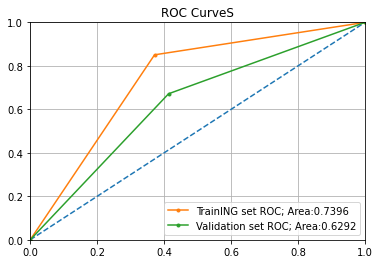

In [14]:
knn = KNeighborsClassifier(n_neighbors=15)      # Declaring KNN model Object
knn.fit(X_train_smote,y_train_smote)            # Fitting training data on KNN model
y_pred_knn = knn.predict(X_train_smote)         # Predicting y values for training split
y_pred_val_knn = knn.predict(x_val)             # Predicting y values for validation split

scores_knn = ScorePrinter(y_train_smote,y_pred_knn,y_val,y_pred_val_knn) # Training and Validation scores for KNN model 
models.append("KNN")

C_precision.append(scores_knn['weighted avg']['precision'])  
C_recall.append(scores_knn['weighted avg']['recall'])
C_f1.append(scores_knn['weighted avg']['f1-score'])
C_accuracy.append(scores_knn['accuracy'])
ROCprint(y_train_smote,y_pred_knn,y_val,y_pred_val_knn)  # Plotting ROC curves for KNN model

# GaussianNB

              precision    recall  f1-score   support

           0       0.76      0.38      0.50     47293
           1       0.59      0.88      0.70     47293

    accuracy                           0.63     94586
   macro avg       0.67      0.63      0.60     94586
weighted avg       0.67      0.63      0.60     94586

**************************************************
              precision    recall  f1-score   support

           0       0.88      0.38      0.53     11852
           1       0.36      0.86      0.51      4748

    accuracy                           0.52     16600
   macro avg       0.62      0.62      0.52     16600
weighted avg       0.73      0.52      0.52     16600



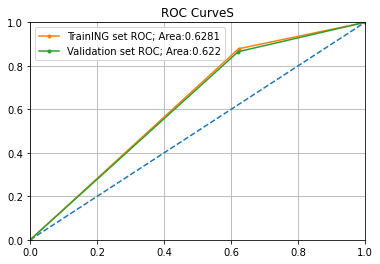

In [15]:
gnb = GaussianNB()
gnb.fit(X_train_smote, y_train_smote)
y_pred_gnb = gnb.predict(X_train_smote)
y_pred_val_gnb = gnb.predict(x_val)

scores_gnb = ScorePrinter(y_train_smote,y_pred_gnb,y_val,y_pred_val_gnb)
models.append("GaussianNB")

C_precision.append(scores_gnb['weighted avg']['precision'])
C_recall.append(scores_gnb['weighted avg']['recall'])
C_f1.append(scores_gnb['weighted avg']['f1-score'])
C_accuracy.append(scores_gnb['accuracy'])
ROCprint(y_train_smote,y_pred_gnb,y_val,y_pred_val_gnb)

# XGBoost

              precision    recall  f1-score   support

           0       0.88      0.68      0.76     47293
           1       0.74      0.90      0.81     47293

    accuracy                           0.79     94586
   macro avg       0.81      0.79      0.79     94586
weighted avg       0.81      0.79      0.79     94586

**************************************************
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     11852
           1       0.48      0.75      0.58      4748

    accuracy                           0.69     16600
   macro avg       0.67      0.71      0.67     16600
weighted avg       0.76      0.69      0.71     16600



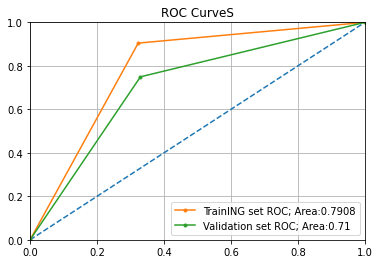

In [10]:
xgb = XGBClassifier(n_estimators=130,#150,#150,    #100
                      learning_rate=0.05,
                      objective='binary:logistic',
                      subsample=0.5,         #0.5
                      colsample_bytree=0.5,  #0.5
                      scale_pos_weight=2.47, #2.20
                      random_state=123)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_train_smote)
y_pred_val_xgb = xgb.predict(x_val)

scores_xgb = ScorePrinter(y_train_smote,y_pred_xgb,y_val,y_pred_val_xgb)
models.append("XGBoost")

C_precision.append(scores_xgb['weighted avg']['precision'])
C_recall.append(scores_xgb['weighted avg']['recall'])
C_f1.append(scores_xgb['weighted avg']['f1-score'])
C_accuracy.append(scores_xgb['accuracy'])
ROCprint(y_train_smote,y_pred_xgb,y_val,y_pred_val_xgb)

# Light Gradient Boosting Machine(LGBM) Model

              precision    recall  f1-score   support

           0       0.87      0.70      0.77     47293
           1       0.75      0.89      0.81     47293

    accuracy                           0.80     94586
   macro avg       0.81      0.80      0.79     94586
weighted avg       0.81      0.80      0.79     94586

**************************************************
              precision    recall  f1-score   support

           0       0.87      0.69      0.77     11852
           1       0.49      0.74      0.59      4748

    accuracy                           0.70     16600
   macro avg       0.68      0.71      0.68     16600
weighted avg       0.76      0.70      0.72     16600



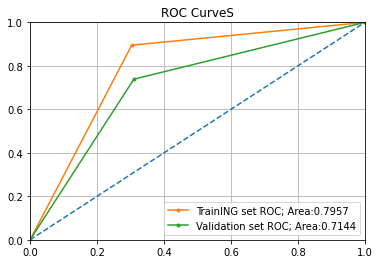

In [11]:
lgbm = LGBMClassifier(n_estimators=130,#150,#150,  #100 
                       learning_rate=0.05, 
                       objective='binary',
                       subsample=0.5,        #0.5 
                       colsample_bytree=0.5, #0.5
                       scale_pos_weight=2.47, #2.20
                       random_state=123)
lgbm.fit(X_train_smote, y_train_smote)
y_pred_lgbm = lgbm.predict(X_train_smote)
y_pred_val_lgbm = lgbm.predict(x_val)

scores_lgbm = ScorePrinter(y_train_smote,y_pred_lgbm,y_val,y_pred_val_lgbm)
models.append("LGBM")

C_precision.append(scores_lgbm['weighted avg']['precision'])
C_recall.append(scores_lgbm['weighted avg']['recall'])
C_f1.append(scores_lgbm['weighted avg']['f1-score'])
C_accuracy.append(scores_lgbm['accuracy'])
ROCprint(y_train_smote,y_pred_lgbm,y_val,y_pred_val_lgbm)

# Adaboost

              precision    recall  f1-score   support

           0       0.76      0.70      0.73     47293
           1       0.72      0.78      0.75     47293

    accuracy                           0.74     94586
   macro avg       0.74      0.74      0.74     94586
weighted avg       0.74      0.74      0.74     94586

**************************************************
              precision    recall  f1-score   support

           0       0.84      0.70      0.76     11852
           1       0.47      0.68      0.56      4748

    accuracy                           0.69     16600
   macro avg       0.66      0.69      0.66     16600
weighted avg       0.74      0.69      0.71     16600



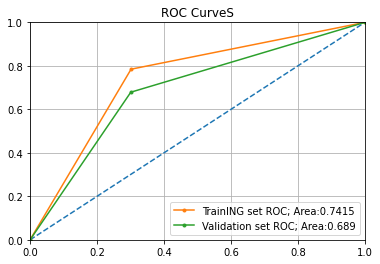

In [12]:
ada = AdaBoostClassifier(algorithm='SAMME.R', random_state=42,learning_rate=0.05)
ada.fit(X_train_smote, y_train_smote)
y_pred_ada = ada.predict(X_train_smote)
y_pred_val_ada = ada.predict(x_val)

scores_ada = ScorePrinter(y_train_smote,y_pred_ada,y_val,y_pred_val_ada)
models.append("AdaBoost")

C_precision.append(scores_ada['weighted avg']['precision'])
C_recall.append(scores_ada['weighted avg']['recall'])
C_f1.append(scores_ada['weighted avg']['f1-score'])
C_accuracy.append(scores_ada['accuracy'])
ROCprint(y_train_smote,y_pred_ada,y_val,y_pred_val_ada)

# Soft Voting for LGBM and XGBoost

In [13]:
estimators = []                          # array containing estimators to be used in voting classifier
estimators.append(('xgb',xgb))
estimators.append(('lgbm',lgbm))

Classifier = VotingClassifier(estimators,voting='soft')       # Initialising a soft voting classifier
soft_voter_xgb_lgbm = Classifier.fit(X_train_smote,y_train_smote)  # Fitting data on soft voting classifier


              precision    recall  f1-score   support

           0       0.87      0.69      0.77     47293
           1       0.74      0.90      0.81     47293

    accuracy                           0.79     94586
   macro avg       0.81      0.79      0.79     94586
weighted avg       0.81      0.79      0.79     94586

**************************************************
              precision    recall  f1-score   support

           0       0.87      0.68      0.76     11852
           1       0.48      0.75      0.59      4748

    accuracy                           0.70     16600
   macro avg       0.68      0.71      0.68     16600
weighted avg       0.76      0.70      0.71     16600



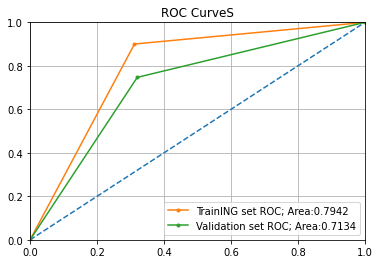

In [14]:
soft_voter_xgb_lgbm.fit(X_train_smote, y_train_smote)
y_pred_svxl = soft_voter_xgb_lgbm.predict(X_train_smote)   # Predicting y values for training data
y_pred_val_svxl = soft_voter_xgb_lgbm.predict(x_val)       #Pre dicting y values for validation data

scores_svxl = ScorePrinter(y_train_smote,y_pred_svxl,y_val,y_pred_val_svxl)
models.append("Voting Classifier")
 
C_precision.append(scores_svxl['weighted avg']['precision'])
C_recall.append(scores_svxl['weighted avg']['recall'])
C_f1.append(scores_svxl['weighted avg']['f1-score'])
C_accuracy.append(scores_svxl['accuracy'])
ROCprint(y_train_smote,y_pred_svxl,y_val,y_pred_val_svxl)

# Random Forest Classifier

In [15]:
RFC = RandomForestClassifier(max_depth=2,n_estimators=50)
df_x=X_train_smote
df_y=y_train_smote

In [16]:

n_splits = 5 
kf = KFold(n_splits=n_splits,shuffle=True,random_state = 42)   # Initialising K-fold (k=5) cross validator

for train_index, test_index in tqdm(kf.split(df_x)):
    X_train_rf, X_val_rf = df_x.loc[train_index], df_x.loc[test_index]
    y_train_rf, y_val_rf = np.array(df_y)[train_index], np.array(df_y)[test_index]
    RFC.fit(X_train_rf,y_train_rf)


5it [00:29,  5.91s/it]


              precision    recall  f1-score   support

           0       0.77      0.66      0.71     47293
           1       0.70      0.80      0.75     47293

    accuracy                           0.73     94586
   macro avg       0.73      0.73      0.73     94586
weighted avg       0.73      0.73      0.73     94586

**************************************************
              precision    recall  f1-score   support

           0       0.85      0.66      0.75     11852
           1       0.46      0.72      0.56      4748

    accuracy                           0.68     16600
   macro avg       0.66      0.69      0.65     16600
weighted avg       0.74      0.68      0.69     16600



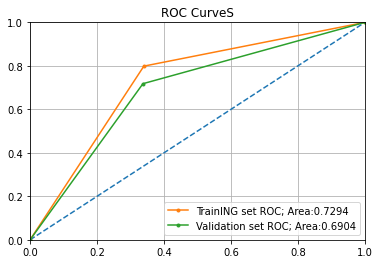

In [17]:
RFC.fit(X_train_smote, y_train_smote)
y_pred_rf = RFC.predict(X_train_smote)
y_pred_val_rf = RFC.predict(x_val)

scores_rf = ScorePrinter(y_train_smote,y_pred_rf,y_val,y_pred_val_rf)
models.append("Random Forest")

C_precision.append(scores_rf['weighted avg']['precision'])
C_recall.append(scores_rf['weighted avg']['recall'])
C_f1.append(scores_rf['weighted avg']['f1-score'])
C_accuracy.append(scores_rf['accuracy'])
ROCprint(y_train_smote,y_pred_rf,y_val,y_pred_val_rf)

# Random Forest Classifier with PCA

In [18]:
RFCP = RandomForestClassifier(max_depth=2,n_estimators=50)

In [19]:
# Taking top 36 Principal Components
pca = PCA(n_components=36)
sc = StandardScaler()
df_x_pca = sc.fit_transform(df_x)
df_x_pca = pd.DataFrame(df_x_pca)

In [20]:
for train_index, test_index in tqdm(kf.split(df_x_pca)):
    X_train_prf, X_val_prf = df_x.loc[train_index], df_x.loc[test_index]
    y_train_prf, y_val_prf = np.array(df_y)[train_index], np.array(df_y)[test_index]
    
    pca_X_train = pca.fit_transform(X_train_prf)
    pca_X_val = pca.transform(X_val_prf)
    
    RFCP.fit(pca_X_train,y_train_prf)



5it [01:03, 12.66s/it]


              precision    recall  f1-score   support

           0       0.76      0.67      0.71     47293
           1       0.70      0.79      0.74     47293

    accuracy                           0.73     94586
   macro avg       0.73      0.73      0.73     94586
weighted avg       0.73      0.73      0.73     94586

**************************************************
              precision    recall  f1-score   support

           0       0.86      0.67      0.75     11852
           1       0.47      0.72      0.57      4748

    accuracy                           0.68     16600
   macro avg       0.66      0.69      0.66     16600
weighted avg       0.74      0.68      0.70     16600



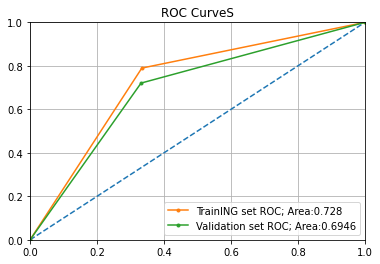

In [21]:
RFCP.fit(X_train_smote, y_train_smote)
y_pred_prf = RFCP.predict(X_train_smote)
y_pred_val_prf = RFCP.predict(x_val)

scores_prf = ScorePrinter(y_train_smote,y_pred_prf,y_val,y_pred_val_prf)
models.append("Random Forest_PCA")

C_precision.append(scores_prf['weighted avg']['precision'])
C_recall.append(scores_prf['weighted avg']['recall'])
C_f1.append(scores_prf['weighted avg']['f1-score'])
C_accuracy.append(scores_prf['accuracy'])
ROCprint(y_train_smote,y_pred_prf,y_val,y_pred_val_prf)

# Comparison of Model F1-Scores

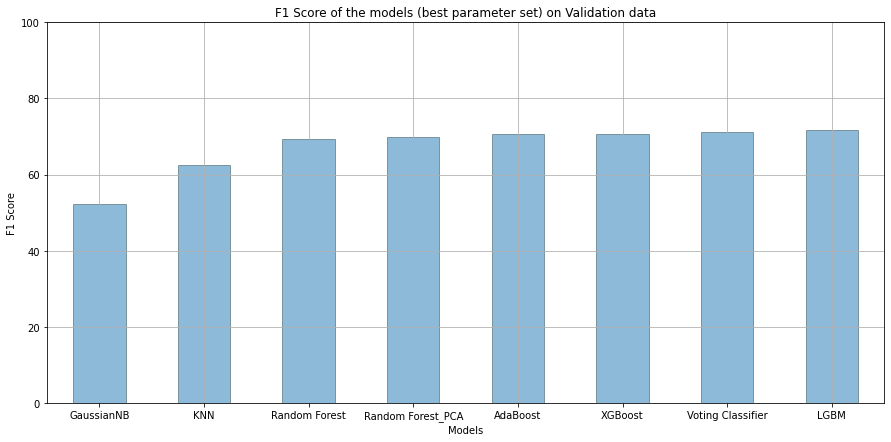

In [22]:
# Model comparison plot
model_compare = pd.DataFrame()
model_compare["Models"] = models
model_compare["Precision"] = C_precision
model_compare["Recall"] = C_recall
model_compare["F1-Score"] = C_f1
model_compare["Accuracy"] = C_accuracy

model_compare["Models"] = model_compare["Models"]
model_compare["Precision"] = model_compare["Precision"]*100
model_compare["Recall"] = model_compare["Recall"]*100
model_compare["F1-Score"] = model_compare["F1-Score"]*100
model_compare["Accuracy"] = model_compare["Accuracy"]*100

model_compare.sort_values(by=["F1-Score"], inplace=True)
model_compare.plot.bar(x="Models", y="F1-Score", alpha=0.5, edgecolor="darkslategray", 
            title="F1 Score of the models (best parameter set) on Validation data", legend=False, 
            figsize=[15,7], rot=0, grid=True, ylim=[0,100])
plt.ylabel("F1 Score")
plt.show()


**Conclusion**
- Among all the models other than Voting classifier , `XGBoost` and `LGBM` are the best performing model as per `F1-score` as an evaluation parameter.
- As `XGBoost` and `LGBM` are the best performing models , it makes sense to use a `Voting classifier` so as to `reduce variability in prediction`. But this decrease in variability comes at the cost of `slightly reduced F1-score`.
- Therefore we selected our `FINAL model as VOTING CLASSIFIER` based on `XGBoost and LGBM`.